In [1]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

from sklearn import neighbors

import math

from cvxopt import solvers, matrix

import time

import scipy

from sklearn.decomposition import PCA
from scipy.special import logsumexp

%matplotlib notebook
#plt.ion()

In [2]:
# Hyperparameters
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# Load training and testing sets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
npzfile = np.load('parameters.npz')

A1 = npzfile['A1']
b1 = npzfile['b1']
A2 = npzfile['A2']
b2 = npzfile['b2']

In [5]:
print(A1.shape)
print(A2.shape)

(128, 784)
(10, 128)


In [6]:
# Get all the inputs and targets
inputs = np.zeros((0, 784))
targets = np.zeros((0, 1))
for batch_idx, (data, target) in enumerate(train_loader):
    x = data.view(-1, 28*28).numpy()
    y = target.numpy()
    
    inputs = np.vstack((inputs, x))
    targets = np.vstack([targets, y.reshape((-1, 1))])

In [7]:
def computeActiveSubspace(whichOut, fig):
    global inputs
    global targets
    global A1
    global A2
    global b1
    global b2
    
    graddamp = np.zeros(inputs.shape)
    outputs = np.zeros(inputs.shape[0])
    correctlyLabeledAsThis = np.zeros(inputs.shape[0], dtype=np.bool)
    correctlyLabeledAsOther = np.zeros(inputs.shape[0], dtype=np.bool)
    incorrectlyLabeledAsThis = np.zeros(inputs.shape[0], dtype=np.bool)
    incorrectlyLabeledAsOther = np.zeros(inputs.shape[0], dtype=np.bool)
    
    
    for sample in range(inputs.shape[0]):
        origOutputHidden = np.maximum(np.matmul(A1, inputs[sample, :].T), 0) + b1
        origOutput = np.matmul(A2, origOutputHidden) + b2

        graddamp[sample, :] = np.matmul(A1[origOutputHidden > 0, :].T, A2[whichOut, origOutputHidden > 0].T).T
        # log(softmax)
        outputs[sample] = origOutput[whichOut]# - logsumexp(origOutput)
        
        outLabel = np.argmax(origOutput)
        if outLabel == whichOut:
            if outLabel == targets[sample]:
                correctlyLabeledAsThis[sample] = True
            else:
                incorrectlyLabeledAsThis[sample] = True
        else:
            if outLabel == targets[sample]:
                correctlyLabeledAsOther[sample] = True
            elif targets[sample] == whichOut:
                incorrectlyLabeledAsOther[sample] = True

        if (sample+1) % 10000 == 0:
            print(sample+1, '/', 60000)
            
    ax1 = fig.add_subplot(3, 1, 1)
    
    U, s, V = np.linalg.svd(np.dot(graddamp.T, graddamp))
    ax1.semilogy(np.power(s[:125], 2), 'o')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Eigenvalue')
    ax1.set_title('Eigenvalues')
    
    for i in range(2):
            ax1 = fig.add_subplot(3,2, 2 + 2*i+1)
            ax2 = fig.add_subplot(3,2, 2 + 2*i+2)

            im = ax1.imshow(U[:, i].reshape(28, 28), cmap='gray', interpolation='none')#, vmin=0, vmax=255)
            fig.colorbar(im, ax=ax1)
            ax2.semilogy(np.matmul(inputs[correctlyLabeledAsOther, :], U[:, i]), np.exp(outputs[correctlyLabeledAsOther]), '.', label='correct not {}'.format(whichOut), c='black', alpha=0.1)
            ax2.semilogy(np.matmul(inputs[correctlyLabeledAsThis, :], U[:, i]), np.exp(outputs[correctlyLabeledAsThis]), '.', label='correct {}'.format(whichOut), c='green', alpha=0.1)
            ax2.semilogy(np.matmul(inputs[incorrectlyLabeledAsOther, :], U[:, i]), np.exp(outputs[incorrectlyLabeledAsOther]), '.', label='incorrect label not {}'.format(whichOut), c='c')
            ax2.semilogy(np.matmul(inputs[incorrectlyLabeledAsThis, :], U[:, i]), np.exp(outputs[incorrectlyLabeledAsThis]), '.', label='incorrect label {}'.format(whichOut), c='r')
            ax2.set_xlabel('$U_{}^T*x$'.format(i+1))
            ax2.set_ylabel('$f_{}(x)$'.format(i+1))
            leg = ax2.legend(fancybox=True, framealpha=0.5)
            for lh in leg.legendHandles: 
                lh._legmarker.set_alpha(1)
                lh._legmarker.set_markersize(5)

<IPython.core.display.Javascript object>


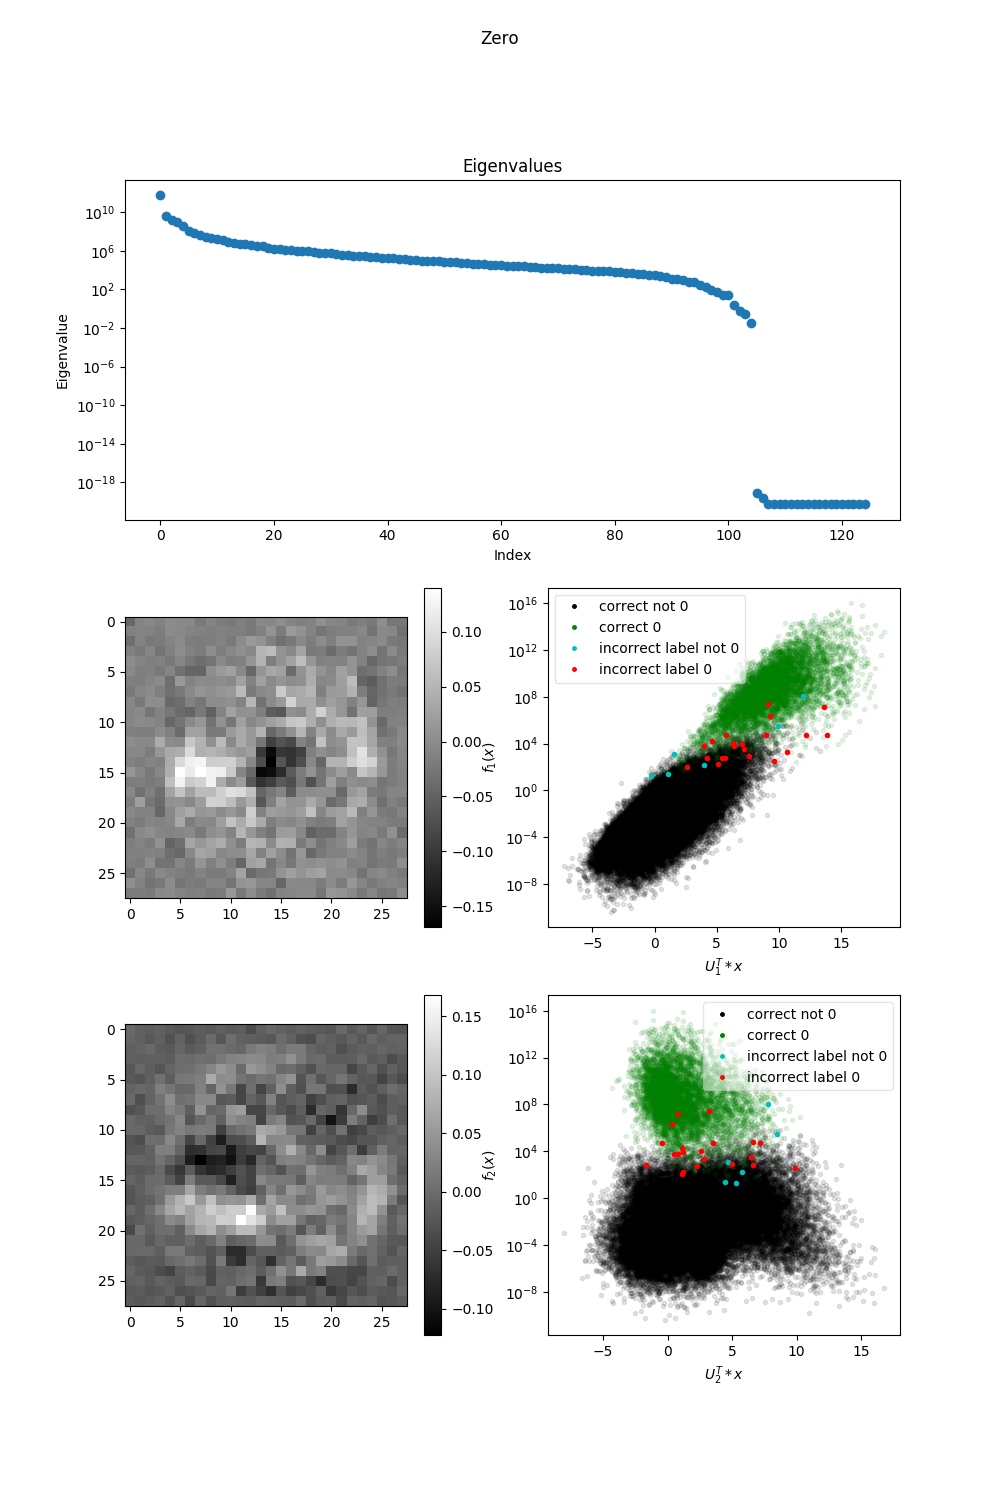

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


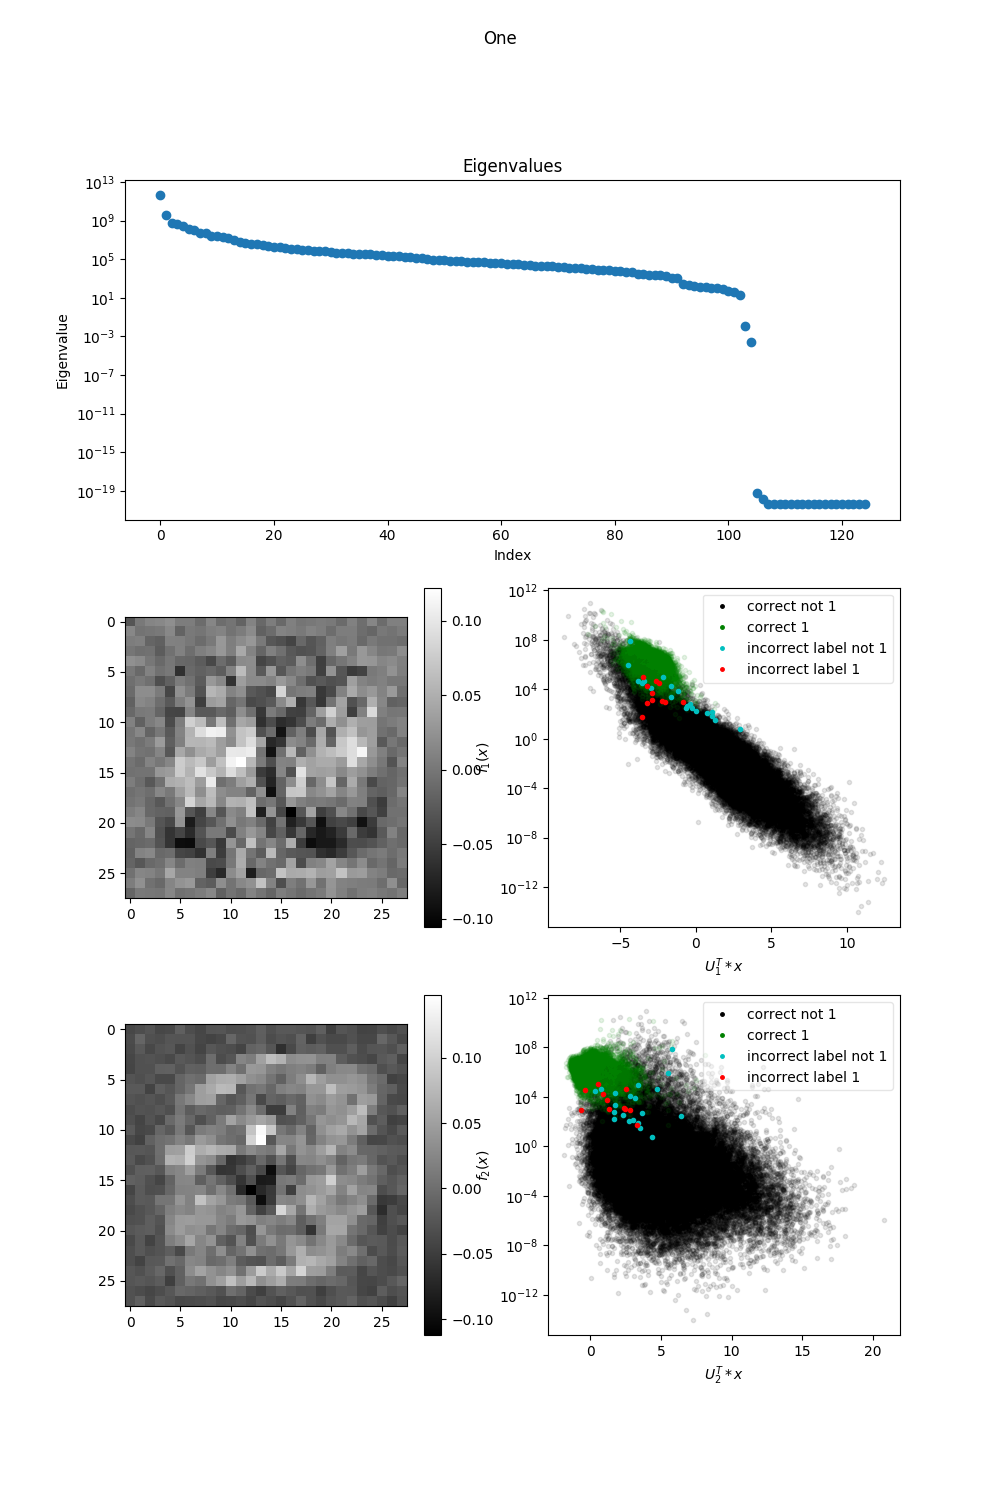

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


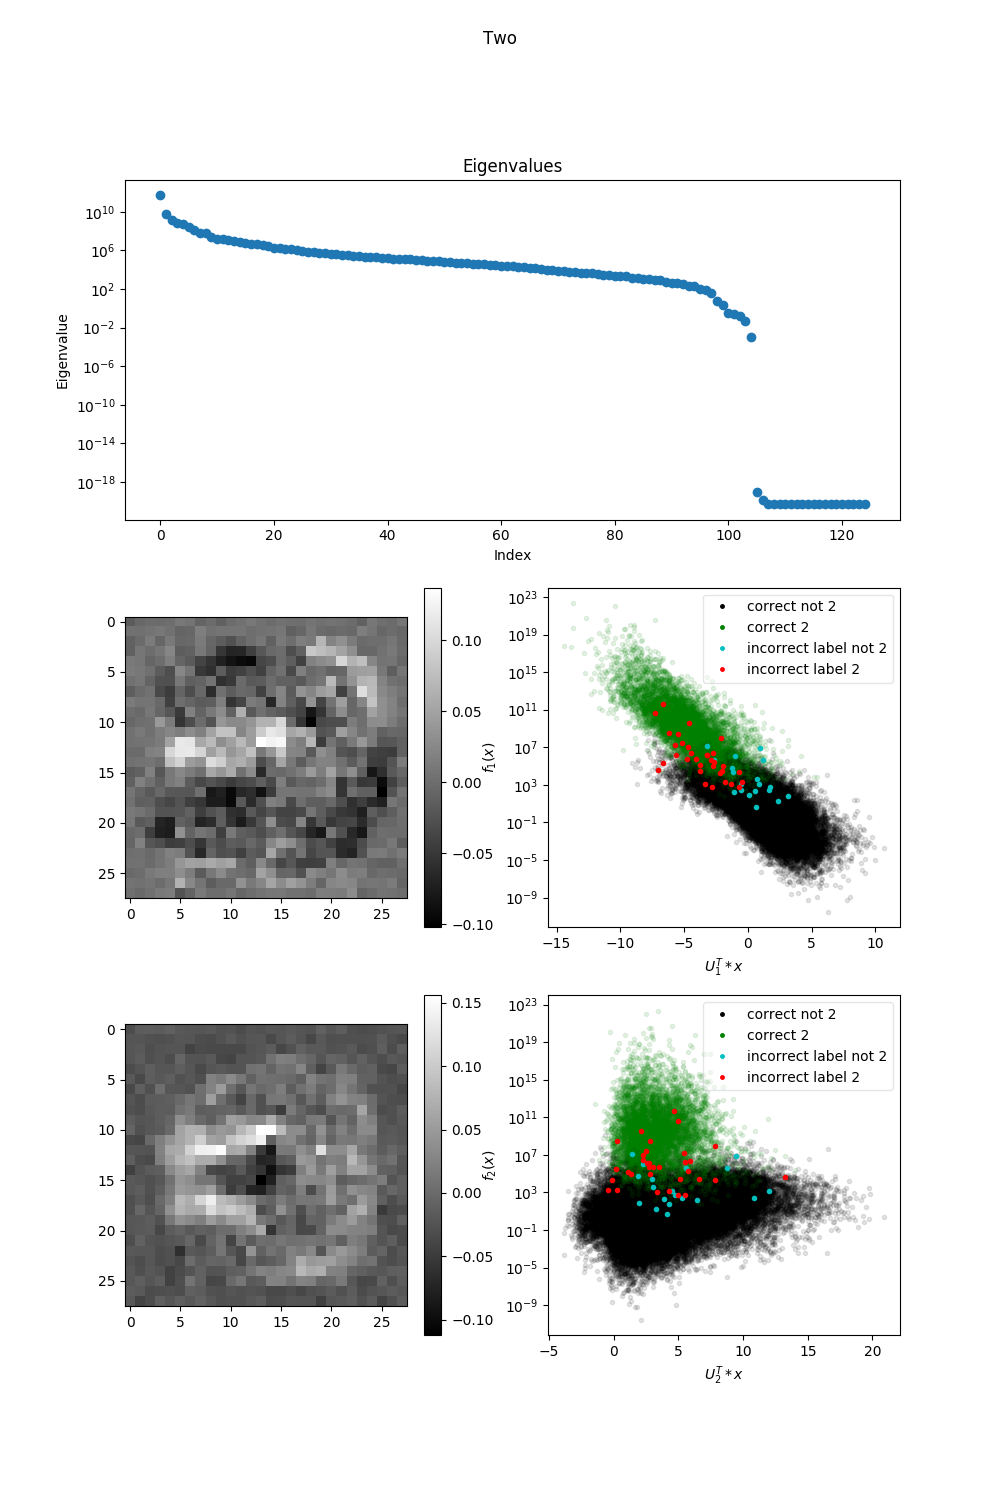

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


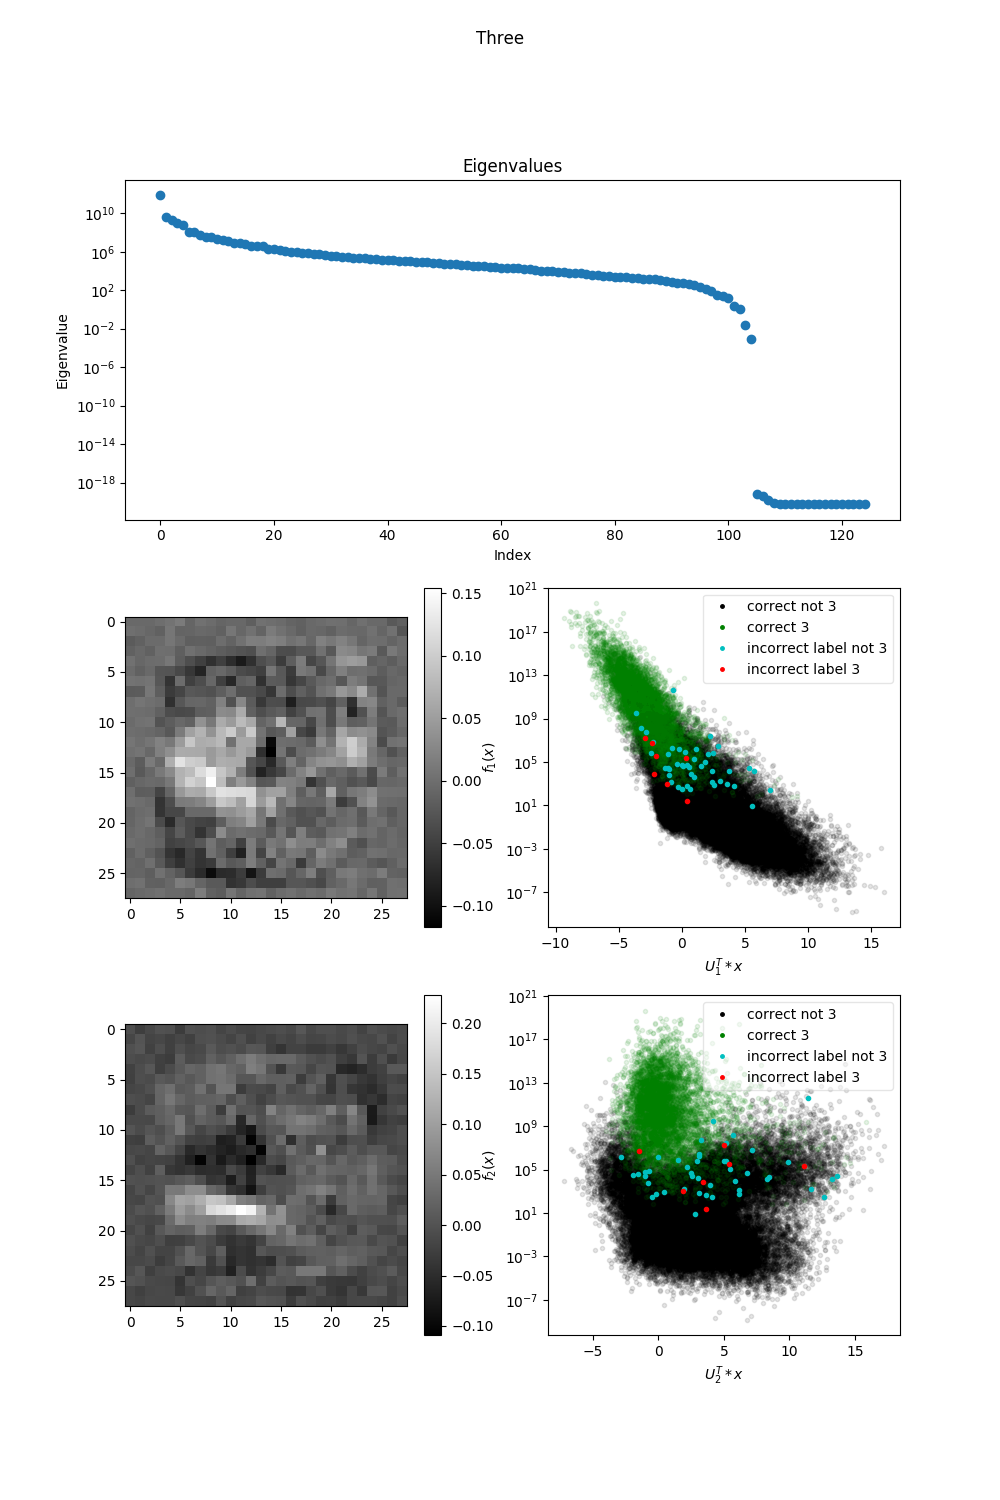

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


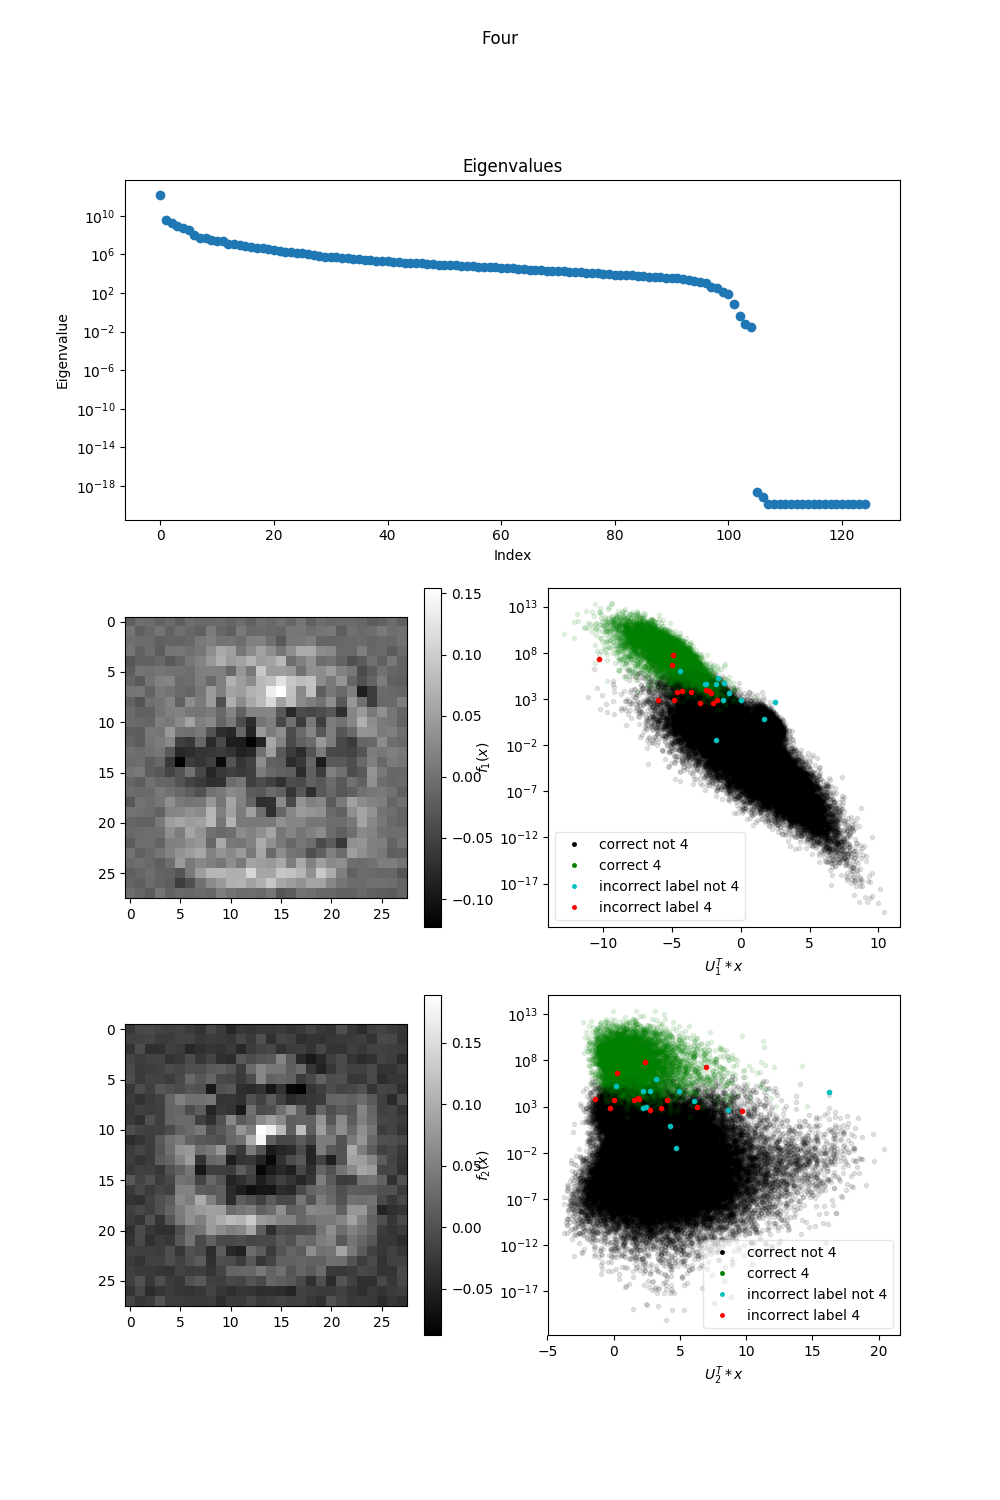

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


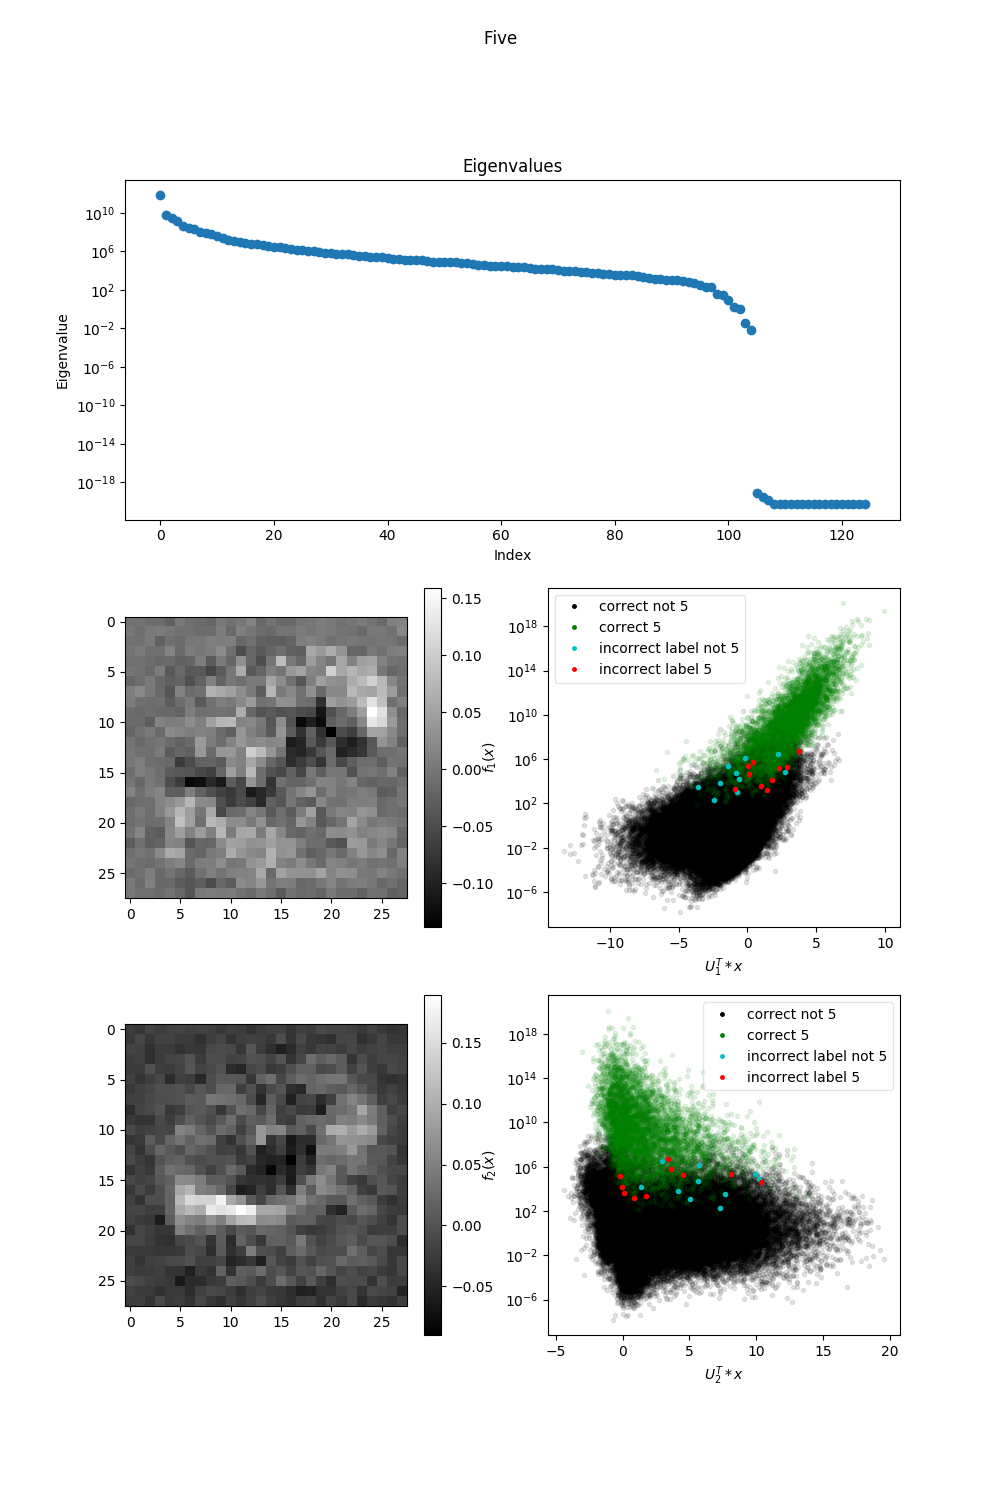

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


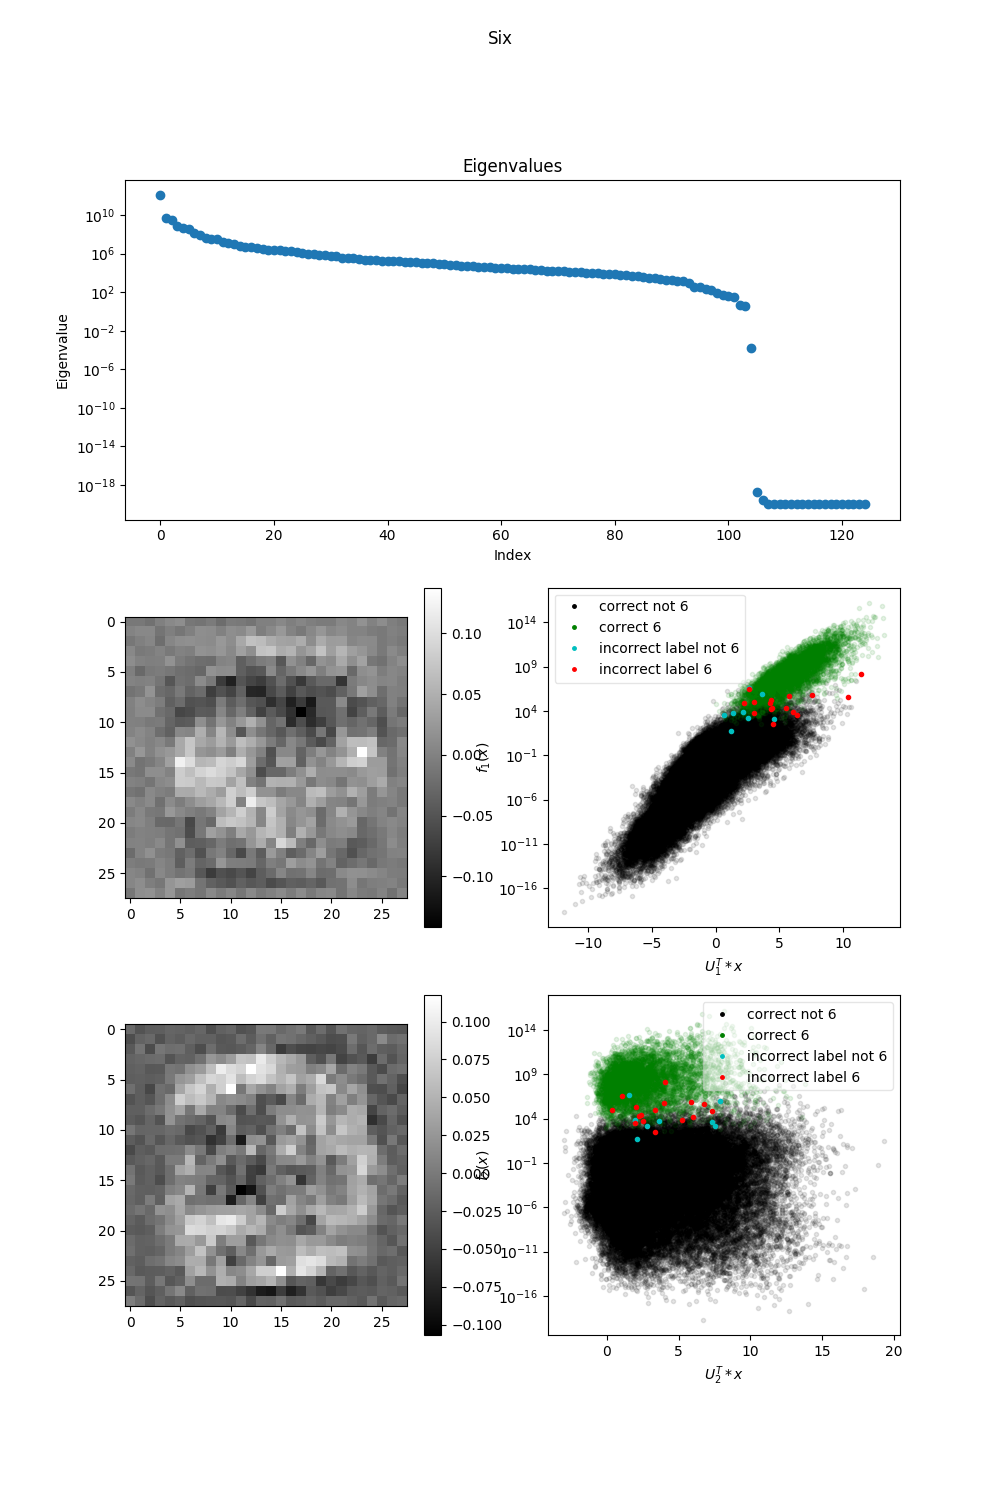

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


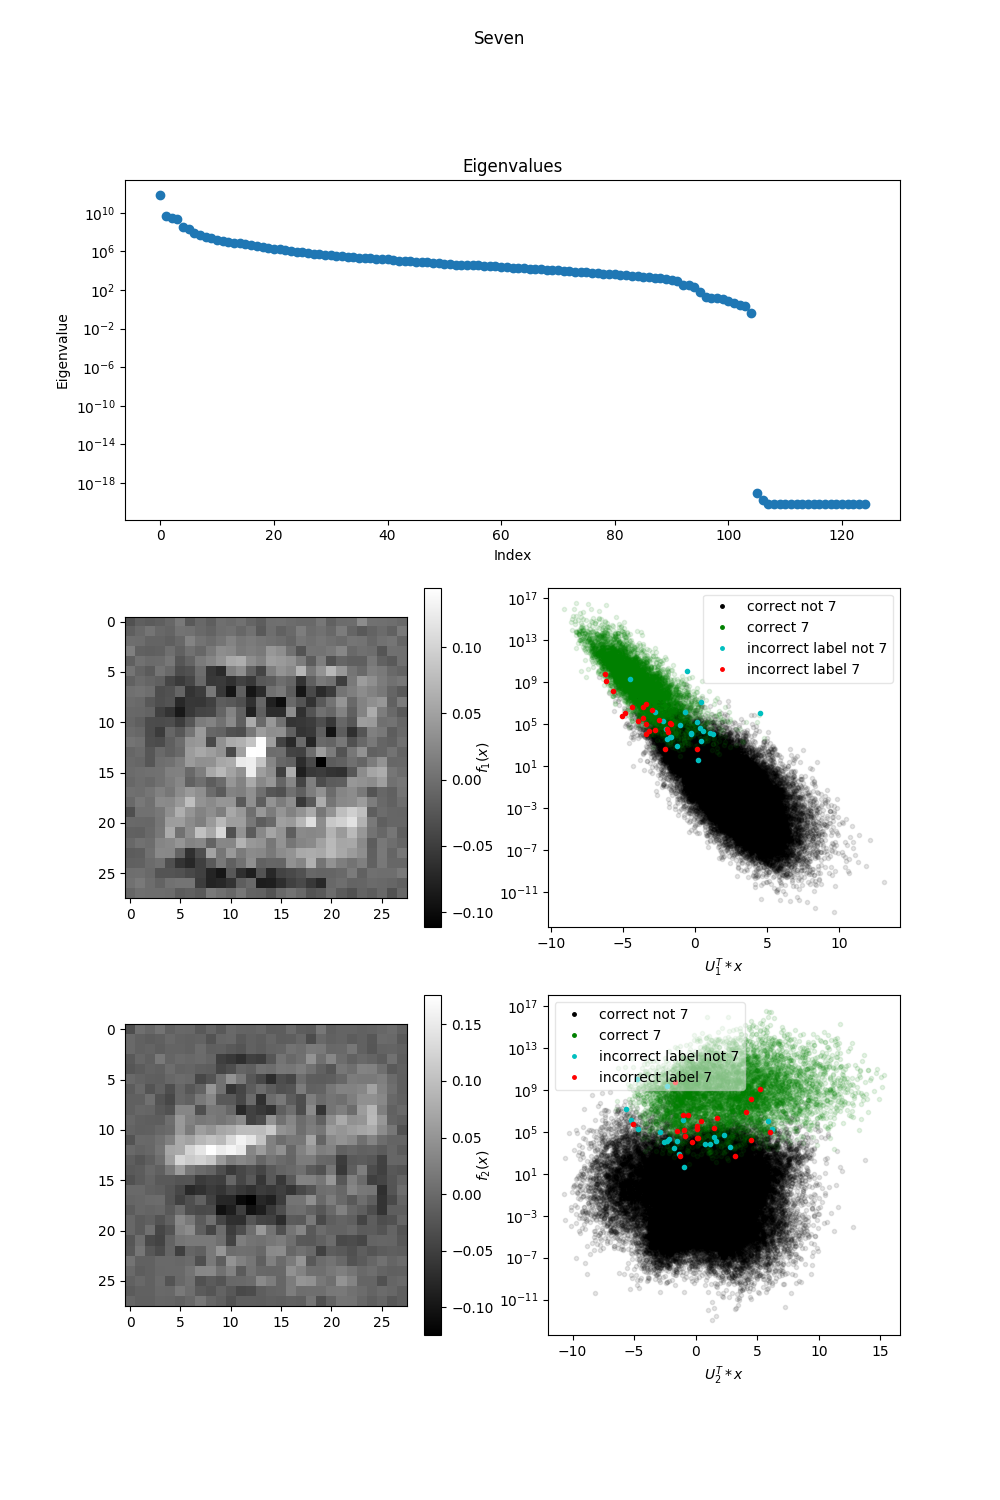

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


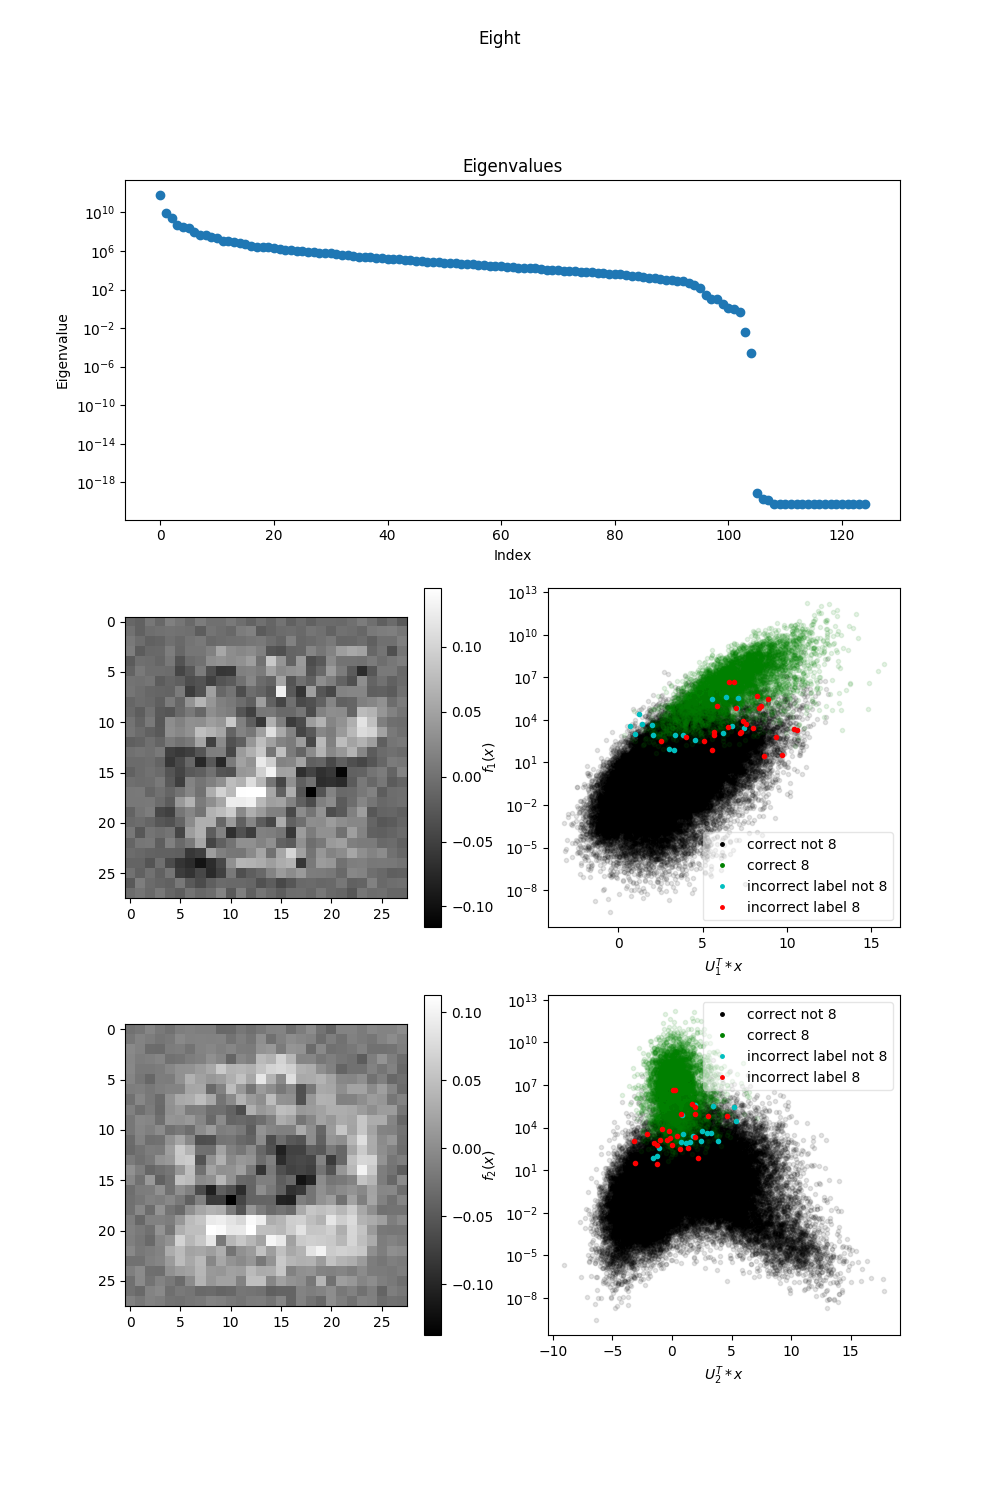

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


<IPython.core.display.Javascript object>


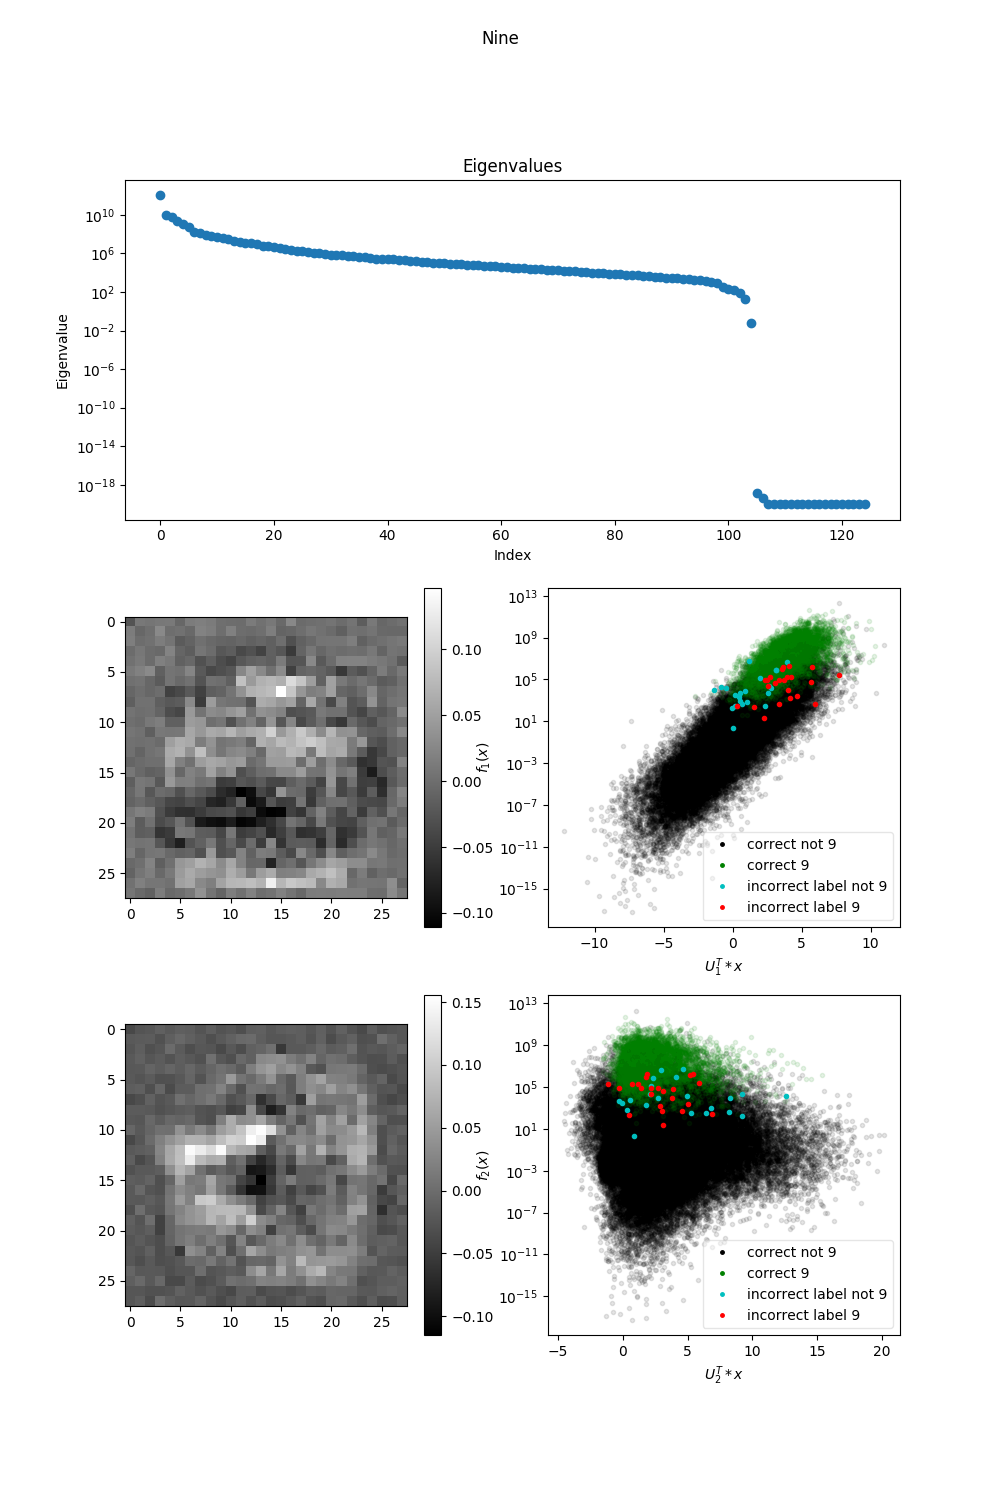

10000 / 60000
20000 / 60000
30000 / 60000
40000 / 60000
50000 / 60000
60000 / 60000


In [8]:
nums = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
for i in range(10):
    fig = plt.figure(figsize=(10, 15))
    computeActiveSubspace(i, fig)
    fig.suptitle(nums[i])
    fig.canvas.draw()
    fig.canvas.flush_events()